# Healthcare Billing Amount Prediction and Time Series Forecasting

# Table of Contents

*   [Data Loading and Exploration](#Data-Loading-and-Exploration)
*   [Data Preprocessing and Feature Engineering](#Data-Preprocessing-and-Feature-Engineering)
*   [Predictive Modeling (XGBoost)](#Predictive-Modeling-(XGBoost))
*   [Hyperparameter Tuning](#Hyperparameter-Tuning)
*   [Model Evaluation](#Model-Evaluation)
*   [Feature Importance](#Feature-Importance)
*   [Time Series Forecasting (Prophet)](#Time-Series-Forecasting-(Prophet))
*   [Understanding the Forecast Components](#Understanding-the-Forecast-Components)
*   [Conclusion](#Conclusion)

In [39]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [40]:
#import dataset
healthcare = pd.read_csv('/content/modified_healthcare_dataset.csv')
healthcare.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Length of Stay
0,Bobby Jackson,19,Female,AB+,Infections,2024-01-31,Matthew Smith,Northwestern Memorial Hospital,Blue Cross,2212.272701,328,Emergency,2024-02-07,Azithromycin,Normal,7
1,Leslie Terry,15,Female,B-,Flu,2019-08-20,Samantha Davies,UI Health (University of Illinois Hospital),UnitedHealthcare,3185.161388,265,Emergency,2019-08-22,Tamiflu,Abnormal,2
2,Danny Smith,50,Female,A+,Cancer,2022-09-22,Tiffany Mitchell,UI Health (University of Illinois Hospital),Blue Cross,72055.214065,205,Elective,2022-10-30,Cisplatin,Inconclusive,38
3,Andrew Watts,24,Female,O+,Asthma,2020-11-18,Kevin Wells,UI Health (University of Illinois Hospital),Aetna,4092.601229,450,Elective,2020-11-19,Prednisone,Normal,1
4,Adrienne Bell,80,Female,A+,Heart Disease,2022-09-19,Kathleen Hanna,Northwestern Memorial Hospital,Cigna,47985.660254,458,Routine,2022-10-27,Beta-blockers,Inconclusive,38


In [41]:
display(healthcare.describe())

,Age,Billing Amount,Room Number,Length of Stay
count,55500.000000,55500.000000,55500.000000,55500.000000
mean,48.001622,21835.044635,301.134829,17.841009
std,21.105827,23574.413594,115.243069,20.272294
min,5.000000,500.220989,101.000000,1.000000
25%,32.000000,4195.525741,202.000000,4.000000
50%,50.000000,11089.537763,302.000000,8.000000
75%,65.000000,35887.703406,401.000000,28.000000
max,90.000000,99997.797977,500.000000,89.000000


In [42]:
display(healthcare.isnull().sum())

,0
Name,0
Age,0
Gender,0
Blood Type,0
Medical Condition,0
Date of Admission,0
Doctor,0
Hospital,0
Insurance Provider,0
Billing Amount,0


In [43]:
display(healthcare.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
 15  Length of Stay      55500 non-null  int64  
dtypes: f

None

In [44]:
healthcare = pd.read_csv('/content/modified_healthcare_dataset.csv')
healthcare['Date of Admission'] = pd.to_datetime(healthcare['Date of Admission'])
healthcare['Discharge Date'] = pd.to_datetime(healthcare['Discharge Date'])

In [45]:
healthcare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Name                55500 non-null  object        
 1   Age                 55500 non-null  int64         
 2   Gender              55500 non-null  object        
 3   Blood Type          55500 non-null  object        
 4   Medical Condition   55500 non-null  object        
 5   Date of Admission   55500 non-null  datetime64[ns]
 6   Doctor              55500 non-null  object        
 7   Hospital            55500 non-null  object        
 8   Insurance Provider  55500 non-null  object        
 9   Billing Amount      55500 non-null  float64       
 10  Room Number         55500 non-null  int64         
 11  Admission Type      55500 non-null  object        
 12  Discharge Date      55500 non-null  datetime64[ns]
 13  Medication          55500 non-null  object    

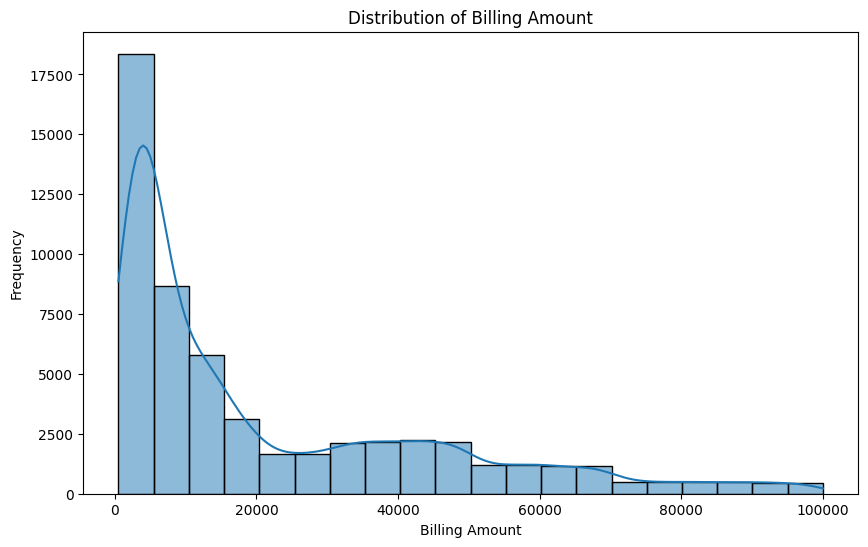

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(healthcare['Billing Amount'], bins=20, kde=True)
plt.title('Distribution of Billing Amount')
plt.xlabel('Billing Amount')
plt.ylabel('Frequency')
plt.show()

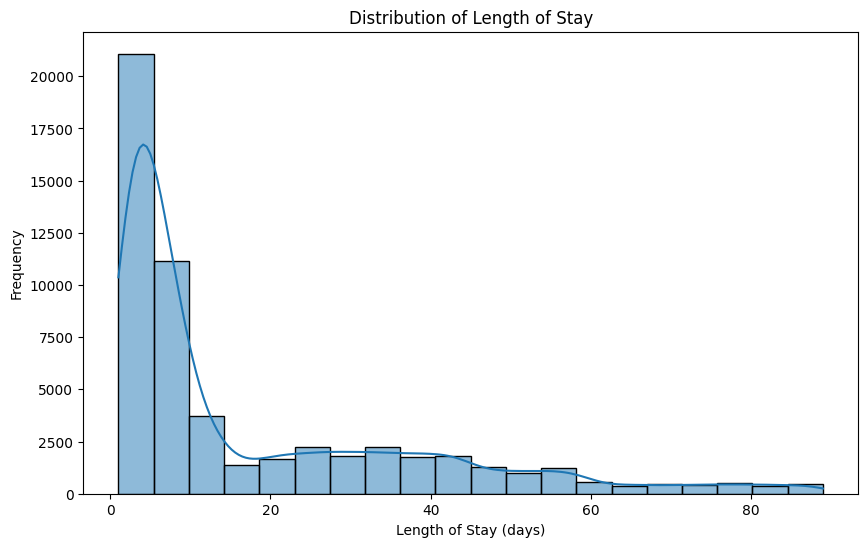

In [47]:
plt.figure(figsize=(10, 6))
sns.histplot(healthcare['Length of Stay'], bins=20, kde=True)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

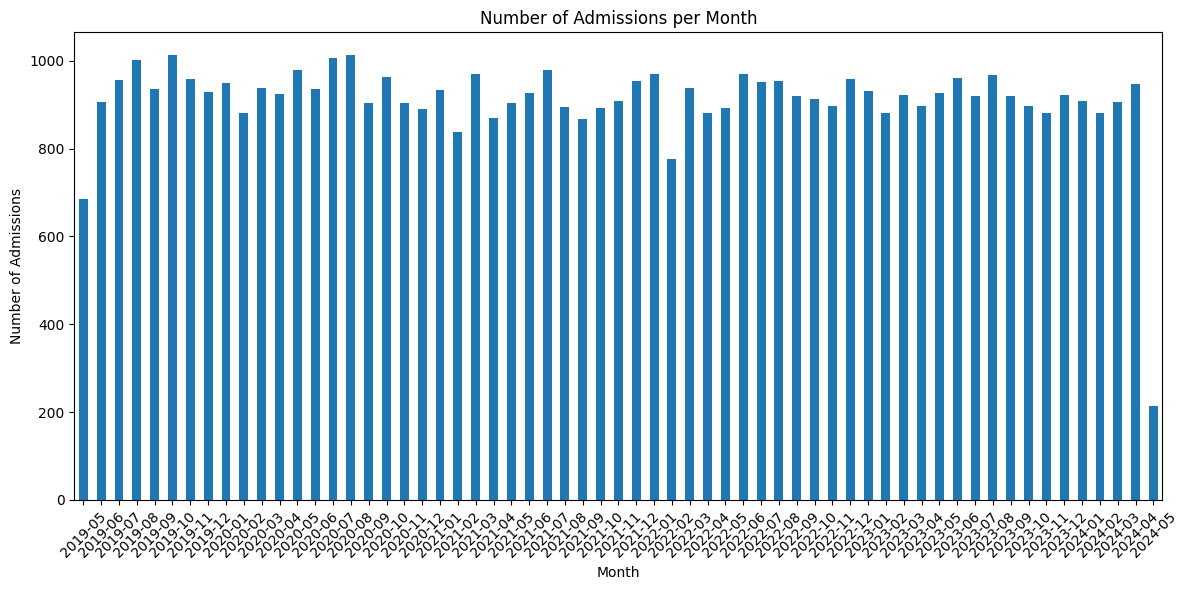

In [48]:
healthcare['Admission Month'] = healthcare['Date of Admission'].dt.to_period('M')
monthly_admissions = healthcare['Admission Month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_admissions.plot(kind='bar')
plt.title('Number of Admissions per Month')
plt.xlabel('Month')
plt.ylabel('Number of Admissions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

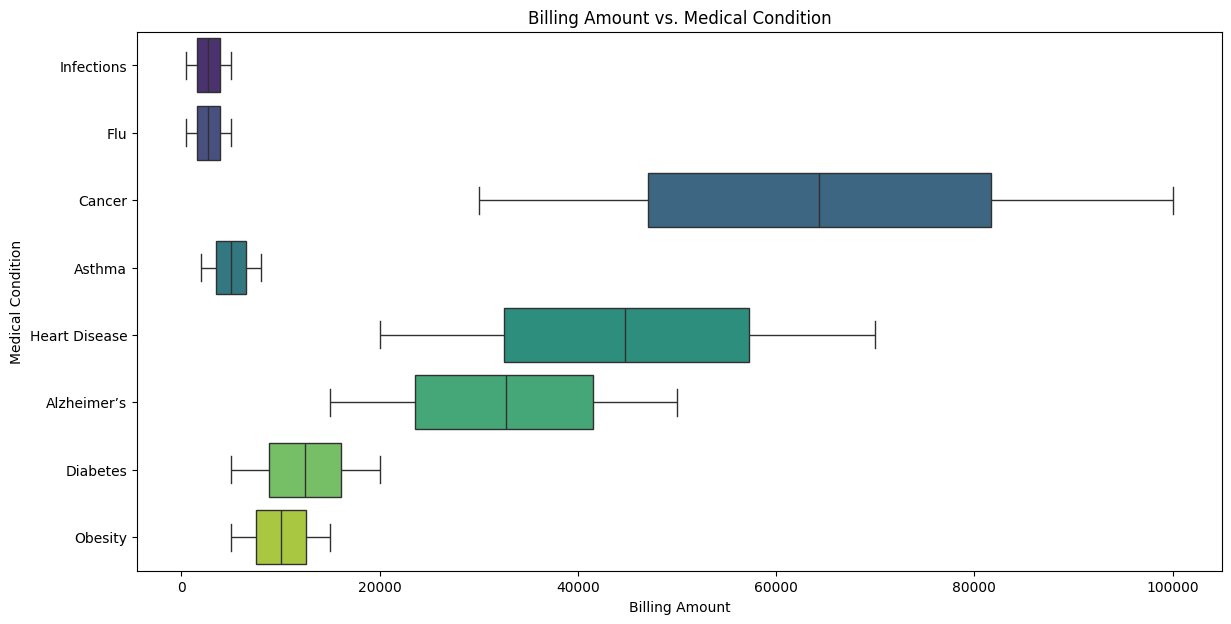

In [49]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=healthcare, x='Billing Amount', y='Medical Condition', palette='viridis', hue='Medical Condition', legend=False)
plt.title('Billing Amount vs. Medical Condition')
plt.xlabel('Billing Amount')
plt.ylabel('Medical Condition')
plt.show()

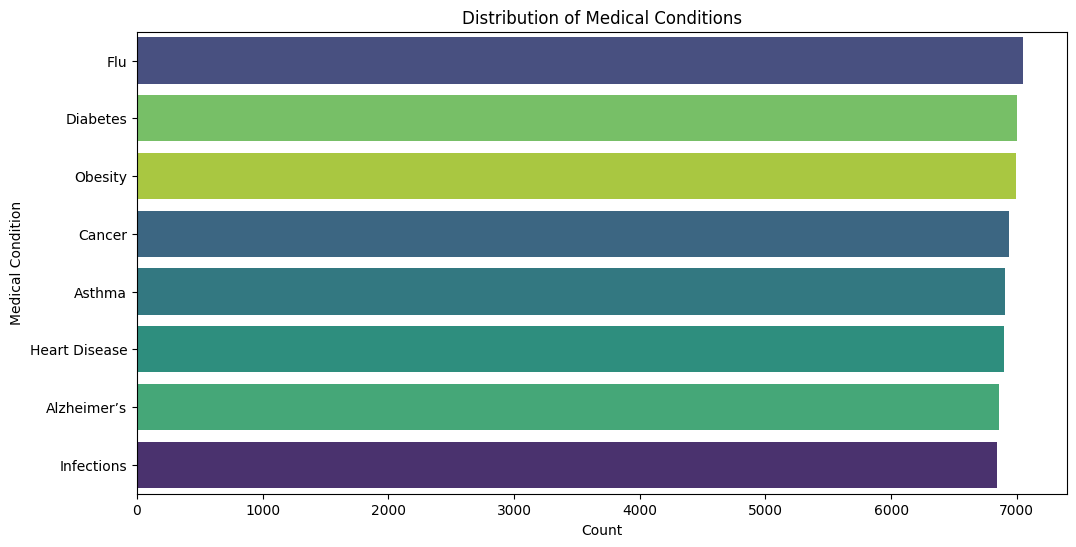

In [50]:
plt.figure(figsize=(12, 6))
sns.countplot(data=healthcare, y='Medical Condition', order=healthcare['Medical Condition'].value_counts().index, palette='viridis', hue='Medical Condition', legend=False)
plt.title('Distribution of Medical Conditions')
plt.xlabel('Count')
plt.ylabel('Medical Condition')
plt.show()

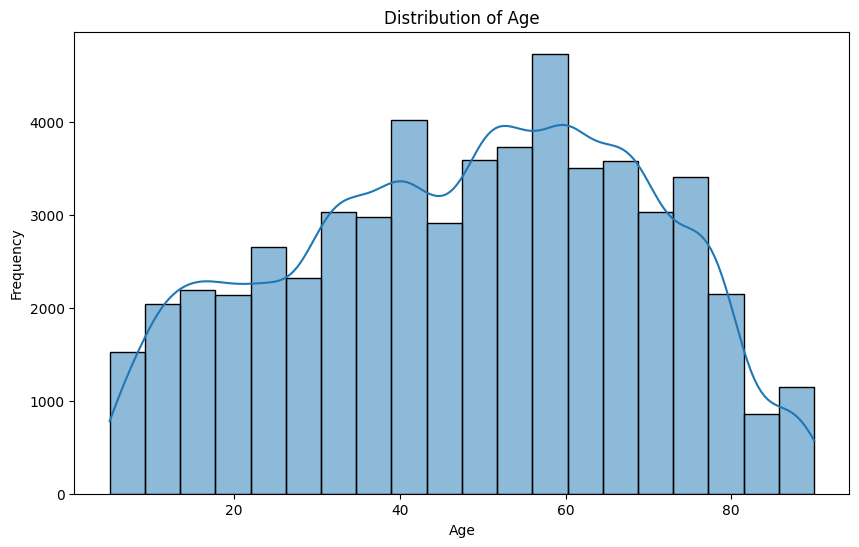

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(healthcare['Age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [52]:
average_billing_by_condition = healthcare.groupby('Medical Condition')['Billing Amount'].mean().sort_values(ascending=False)
display(average_billing_by_condition)

,Billing Amount
Medical Condition,
Cancer,64537.088667
Heart Disease,44913.427049
Alzheimer’s,32543.542291
Diabetes,12503.188470
Obesity,10055.563055
Asthma,5025.348290
Infections,2747.567493
Flu,2744.152050


In [53]:
%pip install xgboost

In [54]:
#Identify and one-hot encode the categorical columns excluding 'Name' and 'Doctor' to prepare the data for modeling.
categorical_cols = healthcare.select_dtypes(include='object').columns.tolist()
categorical_cols_to_encode = [col for col in categorical_cols if col not in ['Name', 'Doctor']]
healthcare_encoded = pd.get_dummies(healthcare, columns=categorical_cols_to_encode, drop_first=False)

In [55]:
#Display the first few rows and the info of the new dataframe to verify the one-hot encoding process.
display(healthcare_encoded.head())
display(healthcare_encoded.info())

,Name,Age,Date of Admission,Doctor,Billing Amount,Room Number,Discharge Date,Length of Stay,Admission Month,Gender_Female,...,Medication_Oseltamivir,Medication_Phentermine,Medication_Prednisone,Medication_Rivastigmine,Medication_Statins,Medication_Tamiflu,Medication_Zanamivir,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
0,Bobby Jackson,19,2024-01-31,Matthew Smith,2212.272701,328,2024-02-07,7,2024-01,True,...,False,False,False,False,False,False,False,False,False,True
1,Leslie Terry,15,2019-08-20,Samantha Davies,3185.161388,265,2019-08-22,2,2019-08,True,...,False,False,False,False,False,True,False,True,False,False
2,Danny Smith,50,2022-09-22,Tiffany Mitchell,72055.214065,205,2022-10-30,38,2022-09,True,...,False,False,False,False,False,False,False,False,True,False
3,Andrew Watts,24,2020-11-18,Kevin Wells,4092.601229,450,2020-11-19,1,2020-11,True,...,False,False,True,False,False,False,False,False,False,True
4,Adrienne Bell,80,2022-09-19,Kathleen Hanna,47985.660254,458,2022-10-27,38,2022-09,True,...,False,False,False,False,False,False,False,False,True,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 66 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   Name                                                  55500 non-null  object        
 1   Age                                                   55500 non-null  int64         
 2   Date of Admission                                     55500 non-null  datetime64[ns]
 3   Doctor                                                55500 non-null  object        
 4   Billing Amount                                        55500 non-null  float64       
 5   Room Number                                           55500 non-null  int64         
 6   Discharge Date                                        55500 non-null  datetime64[ns]
 7   Length of Stay                                        55500 non-null  int64 

None

In [56]:
#Check for missing values in the healthcare_encoded DataFrame.
display(healthcare_encoded.isnull().sum())

,0
Name,0
Age,0
Date of Admission,0
Doctor,0
Billing Amount,0
...,...
Medication_Tamiflu,0
Medication_Zanamivir,0
Test Results_Abnormal,0
Test Results_Inconclusive,0


In [57]:
target_variable = 'Billing Amount'

In [58]:
#Prepare the data by defining features and the target, then split into training and testing sets for model building.
irrelevant_cols = ['Name', 'Doctor', 'Date of Admission', 'Discharge Date', target_variable]
X = healthcare_encoded.drop(columns=irrelevant_cols)
y = healthcare_encoded[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(X_train.head())
display(X_test.head())
display(y_train.head())
display(y_test.head())

,Age,Room Number,Length of Stay,Admission Month,Gender_Female,Gender_Male,Blood Type_A+,Blood Type_A-,Blood Type_AB+,Blood Type_AB-,...,Medication_Oseltamivir,Medication_Phentermine,Medication_Prednisone,Medication_Rivastigmine,Medication_Statins,Medication_Tamiflu,Medication_Zanamivir,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
45174,67,336,78,2022-01,True,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,False
10214,90,486,41,2020-09,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
43199,72,392,41,2023-02,False,True,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
31626,58,225,37,2024-02,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9273,62,279,13,2023-03,True,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False


,Age,Room Number,Length of Stay,Admission Month,Gender_Female,Gender_Male,Blood Type_A+,Blood Type_A-,Blood Type_AB+,Blood Type_AB-,...,Medication_Oseltamivir,Medication_Phentermine,Medication_Prednisone,Medication_Rivastigmine,Medication_Statins,Medication_Tamiflu,Medication_Zanamivir,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
31641,36,339,3,2023-09,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
9246,41,372,1,2023-10,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1583,72,148,28,2019-09,True,False,True,False,False,False,...,False,False,False,False,True,False,False,True,False,False
36506,56,135,12,2020-09,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
11259,61,284,16,2023-02,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False


,Billing Amount
45174,49073.803229
10214,28776.794215
43199,71336.392754
31626,32054.075059
9273,19696.264573


,Billing Amount
31641,14075.024818
9246,1847.479428
1583,42943.887287
36506,10976.333998
11259,30087.320336


In [59]:
#Identify numerical columns, import StandardScaler, instantiate it, fit on training data, transform both training and testing data, and replace original numerical columns with scaled values while preserving column names and index.
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

display(X_train.head())
display(X_test.head())

,Age,Room Number,Length of Stay,Admission Month,Gender_Female,Gender_Male,Blood Type_A+,Blood Type_A-,Blood Type_AB+,Blood Type_AB-,...,Medication_Oseltamivir,Medication_Phentermine,Medication_Prednisone,Medication_Rivastigmine,Medication_Statins,Medication_Tamiflu,Medication_Zanamivir,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
45174,0.896922,0.301596,2.963999,2022-01,True,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,False
10214,1.987686,1.603428,1.140073,2020-09,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
43199,1.134045,0.787613,1.140073,2023-02,False,True,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
31626,0.470102,-0.661759,0.942891,2024-02,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9273,0.659800,-0.193100,-0.240196,2023-03,True,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False


,Age,Room Number,Length of Stay,Admission Month,Gender_Female,Gender_Male,Blood Type_A+,Blood Type_A-,Blood Type_AB+,Blood Type_AB-,...,Medication_Oseltamivir,Medication_Phentermine,Medication_Prednisone,Medication_Rivastigmine,Medication_Statins,Medication_Tamiflu,Medication_Zanamivir,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
31641,-0.573237,0.327633,-0.733149,2023-09,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
9246,-0.336115,0.614036,-0.831739,2023-10,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1583,1.134045,-1.330033,0.499234,2019-09,True,False,True,False,False,False,...,False,False,False,False,True,False,False,True,False,False
36506,0.375253,-1.442858,-0.289491,2020-09,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
11259,0.612375,-0.149706,-0.092310,2023-02,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [60]:
#Identify irrelevant features and drop them from the training and testing sets. Based on the previous steps, 'Admission Month' is a datetime related feature that was converted to period and is not likely to be useful for predicting billing amount directly. Also, Room Number is likely an identifier and not relevant to billing amount.
irrelevant_features = ['Admission Month', 'Room Number']
X_train_selected = X_train.drop(columns=irrelevant_features)
X_test_selected = X_test.drop(columns=irrelevant_features)

display(X_train_selected.head())
display(X_test_selected.head())

,Age,Length of Stay,Gender_Female,Gender_Male,Blood Type_A+,Blood Type_A-,Blood Type_AB+,Blood Type_AB-,Blood Type_B+,Blood Type_B-,...,Medication_Oseltamivir,Medication_Phentermine,Medication_Prednisone,Medication_Rivastigmine,Medication_Statins,Medication_Tamiflu,Medication_Zanamivir,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
45174,0.896922,2.963999,True,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
10214,1.987686,1.140073,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
43199,1.134045,1.140073,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
31626,0.470102,0.942891,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9273,0.659800,-0.240196,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


,Age,Length of Stay,Gender_Female,Gender_Male,Blood Type_A+,Blood Type_A-,Blood Type_AB+,Blood Type_AB-,Blood Type_B+,Blood Type_B-,...,Medication_Oseltamivir,Medication_Phentermine,Medication_Prednisone,Medication_Rivastigmine,Medication_Statins,Medication_Tamiflu,Medication_Zanamivir,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
31641,-0.573237,-0.733149,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
9246,-0.336115,-0.831739,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1583,1.134045,0.499234,True,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
36506,0.375253,-0.289491,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
11259,0.612375,-0.092310,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [61]:
import xgboost as xgb

# Initialize and train the XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 101239391.54955398
Root Mean Squared Error (RMSE): 10061.77874679989
R-squared (R2): 0.8195001053657921
Mean Absolute Error (MAE): 6174.728647744215


In [62]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [63]:
#Instantiate the XGBoost model and the GridSearchCV object with the defined parameter grid and cross-validation strategy.
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [64]:
#Train the GridSearchCV object on the training data to find the best hyperparameters.
grid_search.fit(X_train_selected, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [65]:
print("Best hyperparameters found by GridSearchCV:")
display(grid_search.best_params_)

Best hyperparameters found by GridSearchCV:


{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1.0}

In [66]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 93268565.17151338
Root Mean Squared Error (RMSE): 9657.565178217197
R-squared (R2): 0.8337113061579232
Mean Absolute Error (MAE): 6056.403381901304


,0
Length of Stay,0.491951
Medical Condition_Cancer,0.230221
Medical Condition_Heart Disease,0.121187
Medical Condition_Alzheimer’s,0.076576
Medical Condition_Diabetes,0.027868
Medical Condition_Obesity,0.023429
Medical Condition_Infections,0.006729
Medical Condition_Flu,0.004025
Age,0.002727
Admission Type_Routine,0.001675


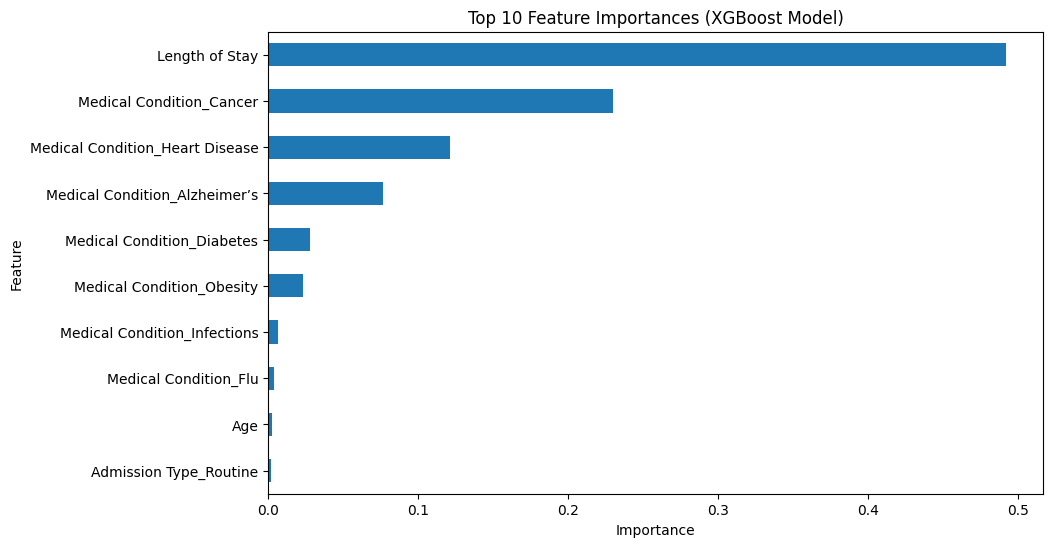

In [67]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a pandas Series for better visualization
feature_importance_series = pd.Series(feature_importances, index=X_train_selected.columns)

# Sort features by importance
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

# Display the top N features (e.g., top 10)
display(sorted_feature_importances.head(10))

# Optionally, visualize the feature importances
plt.figure(figsize=(10, 6))
sorted_feature_importances.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances (XGBoost Model)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Invert y-axis to show the most important feature at the top
plt.show()

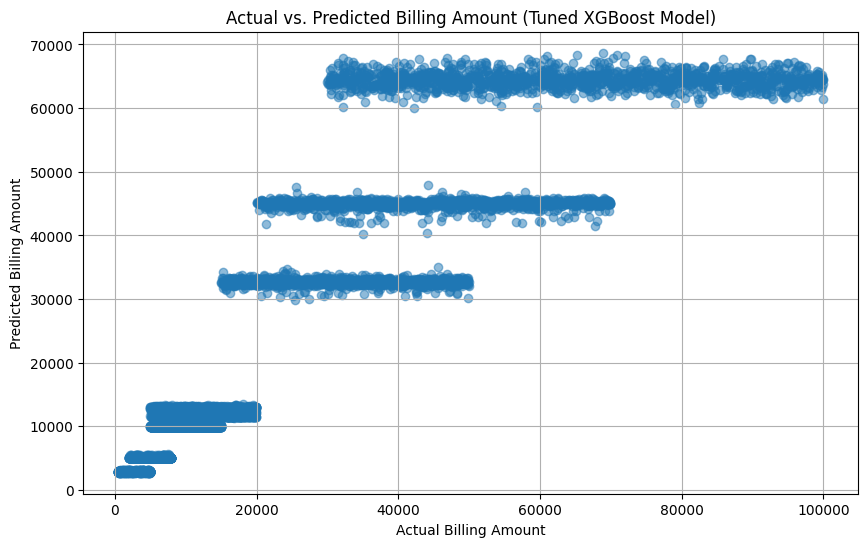

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Billing Amount')
plt.ylabel('Predicted Billing Amount')
plt.title('Actual vs. Predicted Billing Amount (Tuned XGBoost Model)')
plt.grid(True)
plt.show()

### Data Analysis Key Findings

*   The target variable for the predictive model was identified as 'Billing Amount'.
*   Categorical variables, excluding 'Name' and 'Doctor', were successfully converted into a numerical format using one-hot encoding.
*   No missing values were found in the dataset after handling categorical variables.
*   The data was split into training (80%) and testing (20%) sets.
*   Numerical features in both the training and testing sets were scaled using `StandardScaler`.
*   The features 'Admission Month' and 'Room Number' were removed from the dataset.
* The best hyperparameters found by `GridSearchCV` for the XGBoost model are: `colsample_bytree`: 1.0, `learning_rate`: 0.1, `max_depth`: 3, `n_estimators`: 100, and `subsample`: 1.0.
* The tuned XGBoost model evaluated on the test set achieved a Mean Squared Error (MSE) of 93268565.17, a Root Mean Squared Error (RMSE) of 9657.57, an R-squared (R2) of 0.8337, and a Mean Absolute Error (MAE) of 6056.40.
* The R-squared value of approximately 0.83 suggests that the tuned XGBoost model explains about 83.4\% of the variance in the target variable, indicating good performance.



In [69]:
#Calculate the average billing amount for each month by grouping the healthcare dataframe by 'Admission Month' and taking the mean of 'Billing Amount'. Then, store the results in a new dataframe.
monthly_avg_billing = healthcare.groupby('Admission Month')['Billing Amount'].mean().reset_index()
display(monthly_avg_billing.head())

,Admission Month,Billing Amount
0,2019-05,21821.505444
1,2019-06,20387.029845
2,2019-07,22228.989806
3,2019-08,21822.225430
4,2019-09,22469.416924


In [70]:
#Rename and format the columns in the monthly_avg_billing DataFrame to prepare it for Prophet.
monthly_avg_billing = monthly_avg_billing.rename(columns={'Admission Month': 'ds', 'Billing Amount': 'y'})
monthly_avg_billing['ds'] = monthly_avg_billing['ds'].dt.to_timestamp()
display(monthly_avg_billing.head())

,ds,y
0,2019-05-01,21821.505444
1,2019-06-01,20387.029845
2,2019-07-01,22228.989806
3,2019-08-01,21822.225430
4,2019-09-01,22469.416924


In [71]:
%pip install prophet

In [72]:
from prophet import Prophet

model = Prophet()
model.fit(monthly_avg_billing)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [73]:
#Generate a dataframe with future dates for forecasting using the fitted Prophet model and display the head of the resulting dataframe.
future = model.make_future_dataframe(periods=12, freq='M')
display(future.head())
display(future.tail())

/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds
0,2019-05-01
1,2019-06-01
2,2019-07-01
3,2019-08-01
4,2019-09-01


,ds
68,2024-12-31
69,2025-01-31
70,2025-02-28
71,2025-03-31
72,2025-04-30


In [74]:
#Use the fitted Prophet model to make predictions on the future dataframe and display the relevant columns of the resulting forecast.
forecast = model.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

,ds,yhat,yhat_lower,yhat_upper
0,2019-05-01,22075.371237,21321.584954,22815.923560
1,2019-06-01,21539.789054,20762.097485,22266.656760
2,2019-07-01,22057.850842,21350.445339,22732.649730
3,2019-08-01,21355.329692,20637.914151,22098.158826
4,2019-09-01,21589.338749,20859.090721,22302.238111


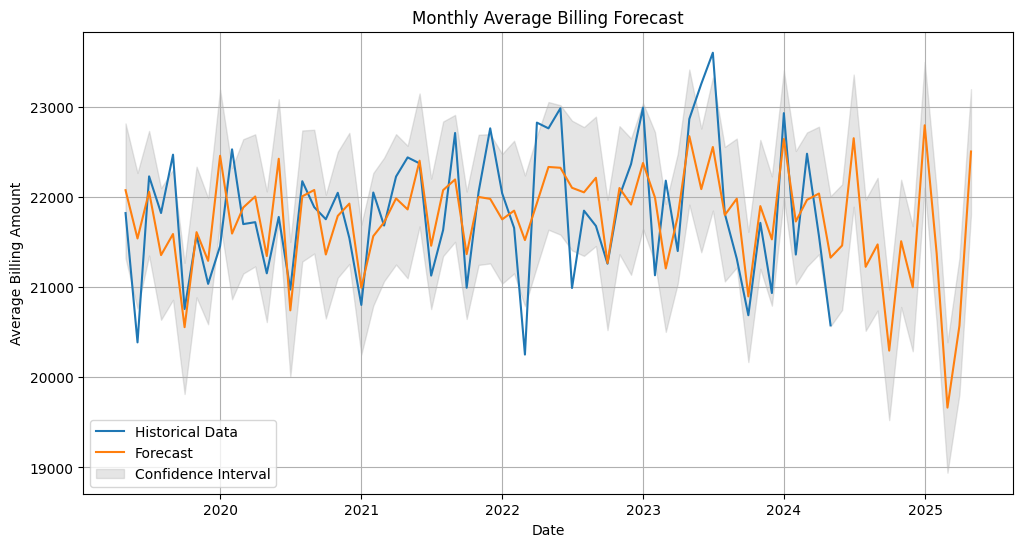

In [75]:
#Plot the historical data, the forecast, and the confidence intervals.
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_billing['ds'], monthly_avg_billing['y'], label='Historical Data')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
plt.title('Monthly Average Billing Forecast')
plt.xlabel('Date')
plt.ylabel('Average Billing Amount')
plt.legend()
plt.grid(True)
plt.show()

Historical Data: The blue line represents the actual average billing amount for each month in your dataset. You can observe any past trends, seasonality, or irregular fluctuations in this line.
Forecast: The orange line is the Prophet model's prediction for the average billing amount in future months. This line represents the model's best estimate based on the patterns it learned from the historical data.
Confidence Interval: The gray shaded area around the forecast line represents the uncertainty in the predictions. The wider the band, the more uncertain the model is about the predicted value for that time period. This interval shows the range within which the actual average billing amount is likely to fall.

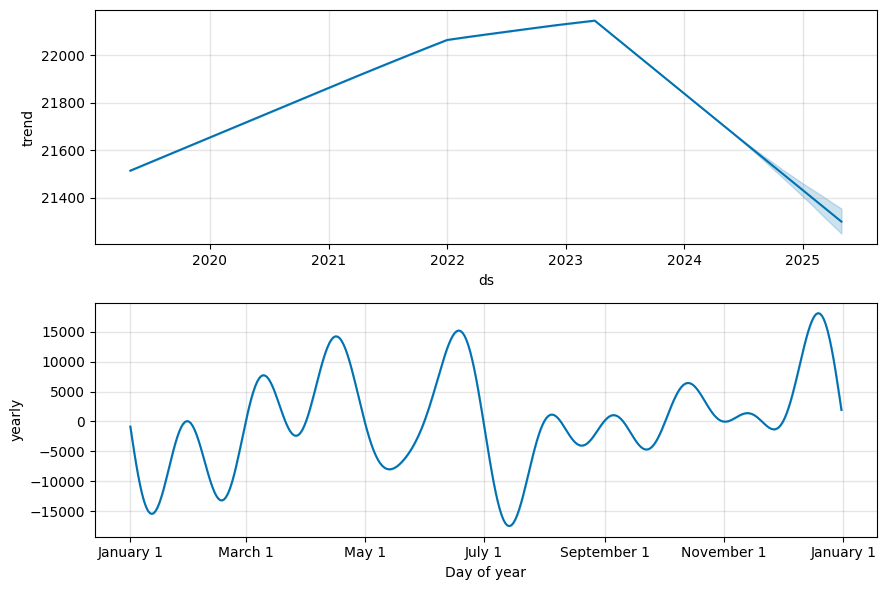

In [76]:
fig = model.plot_components(forecast)

### Understanding the Forecast Components

The `model.plot_components(forecast)` function visualizes the individual components of the time series forecast generated by Prophet. These components help to understand the underlying patterns that contribute to the overall trend.

*   **Trend:** This component shows the long-term direction of the time series. It captures the overall increase or decrease in the average billing amount over time, smoothing out any short-term fluctuations.

*   **Yearly Seasonality:** This component reveals the recurring patterns that happen within a year. For instance, you might see a peak in billing amounts during certain months or seasons due to factors like flu season or holiday-related health issues. The plot shows the average effect for each day of the year.

*   **Weekly Seasonality (if enabled):** If enabled, this component would show recurring patterns within a week, such as higher billing amounts on weekdays compared to weekends. In this case, weekly seasonality was disabled as indicated by the INFO message when the model was fitted.

*   **Daily Seasonality (if enabled):** If enabled, this component would show recurring patterns within a day, such as higher billing amounts during certain hours. In this case, daily seasonality was disabled as indicated by the INFO message when the model was fitted.

By examining these components, you can gain deeper insights into what drives the changes in average billing amounts over time and understand the separate contributions of long-term trends and seasonal patterns to the overall forecast.

### Conclusion

This project involved a comprehensive analysis of the healthcare dataset, focusing on understanding the factors influencing billing amounts and forecasting future trends.

**Key Findings from Exploratory Data Analysis:**

* The distribution of billing amounts and length of stay were visualized, revealing insights into patient billing and hospital stays.
* Monthly admissions were analyzed to understand temporal patterns in hospital visits.
* The relationship between medical conditions and billing amounts was explored, highlighting conditions associated with higher costs.
* Feature importance analysis using the tuned XGBoost model identified 'Length of Stay', 'Medical Condition_Cancer', and 'Medical Condition_Heart Disease' as the most influential factors in predicting billing amount.

**Predictive Modeling:**

* An XGBoost Regressor model was built to predict billing amounts.
* Categorical features were one-hot encoded, and numerical features were scaled to prepare the data for modeling.
* Irrelevant features like 'Admission Month' and 'Room Number' were removed.
* GridSearchCV was used to tune the hyperparameters of the XGBoost model, resulting in improved performance.
* The tuned model achieved an R-squared value of approximately 0.83, indicating that it explains a significant portion of the variance in billing amounts.

**Time Series Forecasting:**

* The monthly average billing amount was calculated and prepared for time series forecasting using the Prophet model.
* The Prophet model was fitted to the historical data and used to forecast the average billing amount for the next 12 months.
* The forecast provides insights into potential future trends in average billing amounts, along with confidence intervals to quantify the uncertainty of the predictions.

Overall, the project successfully explored the dataset, built a predictive model for billing amount, and performed a time series forecast of average monthly billing. The findings can be valuable for healthcare providers in understanding billing patterns, identifying key cost drivers, and anticipating future financial trends.